# AIDI 1002: Machine Learning Programming — Assignment - 2

Due Date : November 23, 2022, 11:59 PM

Fangji Chen

In [1]:
pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# coding=utf-8
import os
import math
import time
import joblib
import random
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import category_encoders as ce
from time import time
from xgboost import *
from scipy.stats import normaltest
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.ensemble import *
from sklearn.datasets import load_digits, make_hastie_10_2, load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# %matplotlib
# %matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 2000)

# 1. Consider this dataset from kaggle. (Download the dataset from following link : https://www.kaggle.com/shrutimechlearn/step-by-step-kmeans-explained-in-detail/data) and answer the following questions :




In [4]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers (1).csv


In [5]:
import io
df = pd.read_csv('./Mall_Customers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df['Genre'] = LabelEncoder().fit_transform(df['Genre'])
df.describe()
X = df.drop(['CustomerID'], axis=1)
X

Genre  Age  Annual_Income_(k$)  Spending_Score
0        1   19                  15              39
1        1   21                  15              81
2        0   20                  16               6
3        0   23                  16              77
4        0   31                  17              40
..     ...  ...                 ...             ...
195      0   35                 120              79
196      0   45                 126              28
197      1   32                 126              74
198      1   32                 137              18
199      1   30                 137              83

[200 rows x 4 columns]

CustomerID            False
Genre                 False
Age                   False
Annual_Income_(k$)    False
Spending_Score        False
dtype: bool


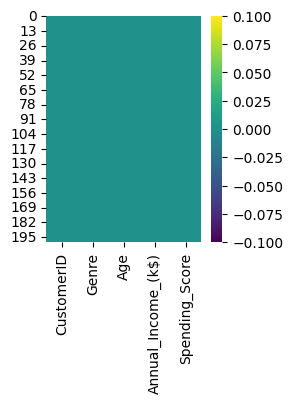

In [7]:
print(df.isnull().any())
plt.figure(figsize=(df.shape[1]/2, 3), dpi=100)
sns.heatmap(df.isnull(), cmap="viridis")

### 1.1 Perform k-means clustering over this dataset using Manhattan distance as the distance-measure. (10 Points)

In [8]:
def kmeans_process(dfx, k):
    tmpX = dfx.copy()
    initial_centers = kmeans_plusplus_initializer(tmpX, k).initialize()
    metric = distance_metric(type_metric.MANHATTAN)
    clf = kmeans(tmpX, initial_centers, metric=metric)
    clf.process()
    clusters = clf.get_clusters()
    final_centers = clf.get_centers()
    return clusters, final_centers

In [9]:
clusters, final_centers = kmeans_process(X, 3)
final_centers = pd.DataFrame(final_centers, columns=X.columns)
X.append(final_centers, ignore_index = True)

Genre        Age  Annual_Income_(k$)  Spending_Score
0    1.000000  19.000000           15.000000       39.000000
1    1.000000  21.000000           15.000000       81.000000
2    0.000000  20.000000           16.000000        6.000000
3    0.000000  23.000000           16.000000       77.000000
4    0.000000  31.000000           17.000000       40.000000
..        ...        ...                 ...             ...
198  1.000000  32.000000          137.000000       18.000000
199  1.000000  30.000000          137.000000       83.000000
200  0.459770  29.103448           62.540230       72.827586
201  0.373333  49.373333           44.866667       39.946667
202  0.526316  40.394737           87.000000       18.631579

[203 rows x 4 columns]

### 1.2 After performing k-means clustering, extract the groups or clusters and add a separate column in your dataset as ‘Labels’ and fill it with cluster number assigned by k-means algorithm. (5 Points)

In [10]:
for i in range(len(clusters)):
    X.loc[clusters[i], 'Labels'] = i
X

Genre  Age  Annual_Income_(k$)  Spending_Score  Labels
0        1   19                  15              39     1.0
1        1   21                  15              81     0.0
2        0   20                  16               6     1.0
3        0   23                  16              77     0.0
4        0   31                  17              40     1.0
..     ...  ...                 ...             ...     ...
195      0   35                 120              79     0.0
196      0   45                 126              28     2.0
197      1   32                 126              74     0.0
198      1   32                 137              18     2.0
199      1   30                 137              83     0.0

[200 rows x 5 columns]

### 1.3 Now, you should be ready with your labeled dataset. Perform standard classification task using logistic regression, decision trees, random forest, and Naive Bayes algorithm. (25 Points)

In [11]:
class Foo:
    def __init__(self, f, lb):
        self.df = f
        self.lb = lb
        self.X, self.y = None, None

    def get_dfx(self):
        if self.X is None:
            self.X = self.df.drop([self.lb], axis=1)
        return self.X

    def get_dfy(self):
        if self.y is None:
            self.y = self.df[self.lb]
        return self.y

    def check_category(self):
        for _, col in enumerate(self.df.columns):
            print("Column Name:", col)
            print("Categorical display:")
            print(pd.value_counts(self.df[col]))
            print('-' * 100)

    def check_null(self):
        print(self.df.isnull().values.any())
        plt.figure(figsize=(8, 3), dpi=100)
        sns.heatmap(self.df.isnull(), cmap="viridis")

    def __label_encoding(self, c):
        self.df[c] = LabelEncoder().fit_transform(self.df[c])
        pass

    def label_encoding(self):
        # print("label encoding:")
        # print(self.df.head())
        for col in self.df.columns:
            if self.df[col].dtype == 'O':
                self.__label_encoding(col)
                # print("label encoding:%s\n%s" % (col, self.df.head()))
        pass

    @staticmethod
    def scaling(f, c, action=None, plot=False):
        tmp = f[[c]]
        if action == 'log':
            tmp = np.log(tmp + 1)
            color = 'r'
        elif action == 'minmax':
            tmp = MinMaxScaler().fit_transform(tmp)
            color = 'g'
        elif action == 'standard':
            tmp = StandardScaler().fit_transform(tmp)
            color = 'b'
        else:
            color = 'k'

        if plot:
            plt.figure(figsize=(7, 2), dpi=70)
            sns.histplot(tmp, kde=True, color=color)
            plt.title("\"%s\" scaling:%s, (%.2f, %.2f)" % (c, action, tmp.min(), tmp.max()))
            plt.show()
        f[c] = tmp
        return f

    @staticmethod
    def search_cv(model, params, fold, verbose=0):
        return RandomizedSearchCV(model, params, cv=fold, verbose=verbose, return_train_score=True, )
        # return RandomizedSearchCV(model, params, cv=fold, verbose=0,
        #                           scoring=scoring, refit=list(scoring.items())[0][0], return_train_score=True, )

    def train_LR(self, x, y, random_state=0, verbose=0):
        model = LogisticRegression()
        params = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4]
        }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "LR", clf

    def train_DT(self, x, y, random_state=0, verbose=0):
        model = DecisionTreeClassifier()
        params = {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_leaf': [5, 10, 20, 50, 100],
            'criterion': ["gini", "entropy"]
        }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "DT", clf

    def train_NB(self, x, y, random_state=0, verbose=0):
        model = GaussianNB()
        params = {
            'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
        }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "NB", clf

    def train_RF(self, x, y, random_state=0, verbose=0):
        model = RandomForestClassifier()
        params = {
            'bootstrap': [True, False],
            'max_depth': [2, 4, 8, 16, 32],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [10, 20, 50, 100, 200],
            'criterion': ['gini', 'entropy']
        }
        # scoring = {
        #     "Accuracy": make_scorer(accuracy_score),
        #     "mean_absolute_error": make_scorer(mean_absolute_error),
        #     "mean_squared_error": make_scorer(mean_squared_error),
        #     "r2_score": make_scorer(r2_score),
        # }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "RF", clf

    def onehot_encoding(self, x_train, x_test):
        X = self.get_dfx()
        categorical_data = [var for var in X.columns if X[var].dtype == 'O']

        encoder = ce.OneHotEncoder(cols=categorical_data)
        x_train = encoder.fit_transform(x_train)
        x_test = encoder.transform(x_test)

        scaler = RobustScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        return x_train, x_test


In [12]:
class Driver:
    def __init__(self, f, lb, testing=True, frac=0.01, test_split_size=0.1):
        self.foo = Foo(f, lb)
        if testing:
            self.foo.label_encoding()
            self.foo.df = self.foo.df.sample(frac=frac, replace=False, random_state=0)
        r = random.randint(1, 10000)
        print("test site split random_state : %d" % r)
        self.X = self.foo.get_dfx()
        self.y = self.foo.get_dfy()
        self.df = self.foo.df.copy(deep=True)
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, test_size=test_split_size, random_state=r, stratify=self.y)
        if not testing:
            self.X_train, self.X_test = self.foo.onehot_encoding(self.X_train, self.X_test)
        print("sample size: %s" % str(self.foo.df.shape))
        print("training data size: %s" % str(self.X_train.shape))
    pass

    def model_select(self, results):
        print("Now the best model is")
        best_model_name = None
        best_accuracy = 0.0
        self.__print_title()
        for _, tup in enumerate(results):
            self.__print_result(tup)
            name = tup[0]
            accuracy = tup[1][2]
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_name = name
        
        algo = best_model_name.split(' ')[0]
        print(
            "%s received the highest average performance with accuracy %.4f. Therefore %s is the most suitable model.\n" % (
            algo, best_accuracy, algo))

    def evaluating(self, callable_, verbose=0):
        self.__print_title()
        buffer = []
        name = None
        # pred_lst = []
        for _ in range(5):
            name, clf = callable_(self.X_train, self.y_train,
                                  random_state=random.randint(1, 10000), verbose=verbose)
            start = time()
            y_pred = clf.predict(self.X_test)
            # pred_lst.append(y_pred)
            cost = (time() - start) * 1000
            # tmp_params = clf.cv_results_['params'][clf.best_index_]
            tup = (
                round(clf.cv_results_['mean_test_score'][clf.best_index_], 3),
                round(clf.cv_results_['std_test_score'][clf.best_index_] * 2, 3),
                round(accuracy_score(self.y_test, y_pred), 3),
                round(precision_score(self.y_test, y_pred, average='macro'), 3),
                round(recall_score(self.y_test, y_pred, average='macro'), 3),
                round(cost, 3),
            )
            buffer.append(np.array(tup))
            self.__print_result((name, tup))
        tup = np.array(buffer).mean(axis=0)
        self.__print_result(("%s avg" % name, tup))
        print()
        # self.df[name] = pd.DataFrame(pred_lst).mode().values.flatten()
        return "%s avg" % name, tup

    @staticmethod
    def __print_title():
        print("%15s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s" % (
            "model", "mean", "std", "accuracy", "precision", "recall", "latency"))

    @staticmethod
    def __print_result(tup):
        name, r = tup
        if name.find("avg") >= 0:
            std = ""
        else:
            std = "+/-%.3f" % r[1]
        print("%15s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s" % (
            "%s" % name, "%.3f" % r[0], std, "%.3f" % r[2], "%.3f" % r[3], "%.3f" % r[4], "%.3f ms" % r[5]))

    def evaluating_model(self, clf):
        pred = clf.predict(self.X_test)
        print('Training set score: {:.4f}'.format(clf.score(self.X_train, self.y_train)))
        print('Test set score: {:.4f}'.format(clf.score(self.X_test, self.y_test)))
        print('Model accuracy score: {0:0.4f}'.format(accuracy_score(self.y_test, pred)))
        print(classification_report(self.y_test, pred))
        pass


In [13]:
def kmeans_process(dfx, k):
    tmpX = dfx.copy()
    initial_centers = kmeans_plusplus_initializer(tmpX, k).initialize()
    metric = distance_metric(type_metric.MANHATTAN)
    clf = kmeans(tmpX, initial_centers, metric=metric)
    clf.process()
    clusters = clf.get_clusters()
    final_centers = clf.get_centers()
    for i in range(len(clusters)):
        tmpX.loc[clusters[i], 'Labels'] = i
    dfy = tmpX['Labels']
    return tmpX

df = pd.read_csv('./Mall_Customers.csv')
df.info()
df['Genre'] = LabelEncoder().fit_transform(df['Genre'])
X = df.drop(['CustomerID'], axis=1)
df_labeled = kmeans_process(X, 3)
go = Driver(df_labeled, 'Labels', testing=False, test_split_size=0.1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
test site split random_state : 2321
sample size: (200, 5)
training data size: (180, 4)


In [14]:
arr = [
    go.evaluating(go.foo.train_RF, verbose=0),
    go.evaluating(go.foo.train_LR, verbose=0),
    go.evaluating(go.foo.train_DT, verbose=0),
    go.evaluating(go.foo.train_NB, verbose=0),
]

          model	      mean	       std	  accuracy	 precision	    recall	   latency
             RF	     0.983	  +/-0.044	     0.950	     0.972	     0.933	  5.532 ms
             RF	     0.983	  +/-0.044	     0.900	     0.949	     0.850	  2.495 ms
             RF	     0.983	  +/-0.027	     0.900	     0.949	     0.850	  2.652 ms
             RF	     0.983	  +/-0.044	     0.950	     0.972	     0.917	  2.982 ms
             RF	     0.983	  +/-0.044	     0.950	     0.972	     0.917	  6.114 ms
         RF avg	     0.983	          	     0.930	     0.963	     0.893	  3.955 ms

          model	      mean	       std	  accuracy	 precision	    recall	   latency
             LR	     0.978	  +/-0.042	     0.900	     0.949	     0.867	  0.229 ms
             LR	     0.972	  +/-0.050	     0.950	     0.972	     0.933	  0.209 ms
             LR	     0.983	  +/-0.044	     0.950	     0.972	     0.933	  0.220 ms
             LR	     0.978	  +/-0.042	     1.000	     1.000	     1.000	  0.240 ms
             LR

### 1.4 Compare the performance of these various supervised learning algorithm and comment on the homogeneity of clusters, like is the clusters or groups are making sense or not ? (10 Points)

***

### 1.4.1. Analyze on previous supervised learning algorithms

LR received the highest average performance with accuracy 0.9700. Therefore LR is the most suitable model.

***

In [15]:
go.model_select(arr)

Now the best model is
          model	      mean	       std	  accuracy	 precision	    recall	   latency
         RF avg	     0.983	          	     0.930	     0.963	     0.893	  3.955 ms
         LR avg	     0.980	          	     0.950	     0.973	     0.933	  0.245 ms
         DT avg	     0.979	          	     0.900	     0.949	     0.850	  0.210 ms
         NB avg	     0.970	          	     0.950	     0.972	     0.933	  0.442 ms
LR received the highest average performance with accuracy 0.9500. Therefore LR is the most suitable model.



***

### 1.4.2. Analyse on the homogeneity of kmeans clusters

As Silhouette Score show, k=5 is the best option.

***

#### 1.4.2.1. Silhouette Score suggests clusters k=5

In [16]:
from sklearn.metrics import silhouette_score

SIL = []
for i in range(2,16):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(df_labeled)
    SIL.append(silhouette_score(df_labeled, kmeans.labels_))
idx = np.argmax(SIL)
a = np.vstack((range(2, 16), SIL))

The optimal cluster number is **6** due to the metric on Silhouette Score.


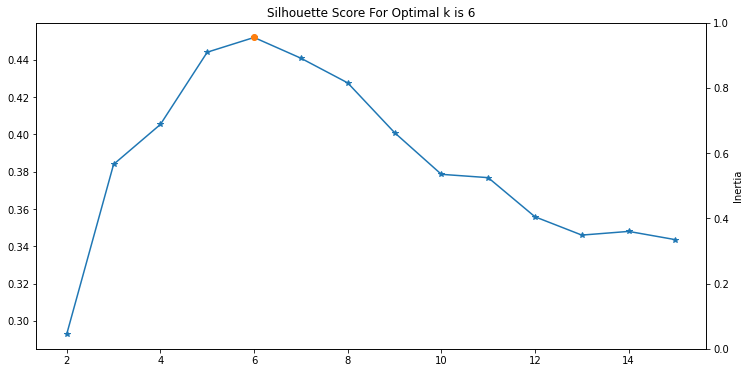

In [17]:
fig,ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.plot(a[0], a[1], marker="*")
ax1.plot(a[0][idx], a[1][idx], marker="o")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Silhouette Score For Optimal k is %s' % str(idx + 2))

print("The optimal cluster number is **%s** due to the metric on Silhouette Score." % str(idx + 2))

#### 1.4.2.2. Elbow plot didn't shows a significent elbow, so I think k=5 suggested by Silhouette Score is the optimal clusters k.

In [18]:
SSE = []
for i in range(2,16):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(df_labeled)
    SSE.append(kmeans.inertia_)
    
from scipy.stats import linregress
a = np.vstack((range(2, 16), SSE))
a = np.concatenate((a.T, np.array([[a.T[-1][0] + 1, a.T[-1][1]]])), axis=0).T
t1 = a[:, :-1].T
t2 = a[:, 1:].T
slopes = [linregress(np.concatenate((np.array([t1[i]]), np.array([t2[i]])), axis=0).T)[0] for i in range(t1.shape[0])]
slope_diff = np.diff(slopes)
idx = np.argmax(slope_diff) + 1

The optimal cluster number is **3** due to the observation on elbow plot.


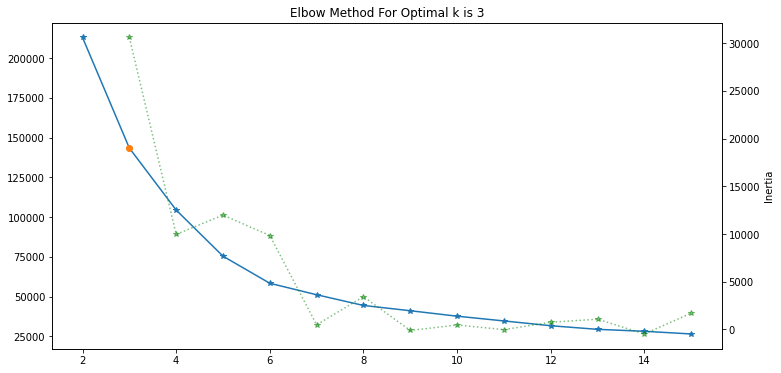

In [19]:
fig,ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.plot(a[:,:-1][0], a[:,:-1][1], marker="*")
ax2.plot(a[:,1:-1][0], slope_diff, c="g", marker="*", linestyle=":", alpha=0.5)
ax1.plot(a[0][idx], a[1][idx], marker="o")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k is %s' % str(idx + 2) )

print("The optimal cluster number is **%s** due to the observation on elbow plot." % str(idx + 2))

#### 1.4.2.3. visualization of kmeans clusters with Manhattan distance metric

***

Visualization could help people to understand the homogeneity of K-Means clusters.

As shown below: clusters k=5 shows the best performance. This is an other evidence to enhance our knowledge from Silhouette Score.

As a conclusion, the optimal k is 5.

***

In [20]:
class ClassifierVisualization:
    def __init__(self, dfx):
        self.X = dfx
        self.y = None
        self.df = None
        self.target_name = 'Labels'
        pass

    # def clf_process(self, f, i, tol=0.01, iter=200, init='k-means++', algo='lloyd'):
    #     df1 = self.kmeans_process(f, i)
    #     lbs = df1['Labels']
    #     #     lbs = KMeans(n_clusters = i, init=init, n_init=10, max_iter=iter, tol=tol, verbose=0, random_state=0, copy_x=True, algorithm=algo).fit(f).labels_
    #     #     lbs = AgglomerativeClustering(linkage='single', n_clusters=i).fit(f).labels_
    #     #     lbs = SpectralClustering(n_clusters=i).fit(f).labels_
    #     #     lbs = OPTICS(min_samples=5,xi=0.001,min_cluster_size=0.3).fit(f).labels_
    #     #     lbs = DBSCAN(eps=1.5).fit(f).labels_

    def labeling_data(self, k):
        from pyclustering.cluster.kmeans import kmeans
        self.df = self.X.copy()
        initial_centers = kmeans_plusplus_initializer(self.X, k).initialize()
        metric = distance_metric(type_metric.MANHATTAN)
        clf = kmeans(self.X, initial_centers, metric=metric)
        clf.process()
        clusters = clf.get_clusters()
        final_centers = clf.get_centers()
        for i in range(len(clusters)):
            self.df.loc[clusters[i], self.target_name] = i
        self.y = self.df['Labels']
        return self.df

    def plot3d(self, ax, x, labels):
        ax.scatter3D(x[:, 0],
                     x[:, 1],
                     x[:, 2],
                     c=labels,
                     cmap='Paired',  # 'prism', # 'Set1', #
                     edgecolor="k",
                     s=40,
                     alpha=.9
                     )
        ax.set_title("Visualizations on the first three PCA components")
        ax.set_xlabel("1st eigenvector")
        ax.w_xaxis.set_ticklabels([])
        ax.set_ylabel("2nd eigenvector")
        ax.w_yaxis.set_ticklabels([])
        ax.set_zlabel("3rd eigenvector")
        ax.w_zaxis.set_ticklabels([])

    def visualize_clusters(self):
        px = PCA().fit_transform(self.X)
        fig = plt.figure(figsize=(18, 18), dpi=100)
        gs = GridSpec(3, 3, figure=fig)
        ax11 = fig.add_subplot(gs[0, 0], projection='3d', elev=0, azim=-45)
        ax12 = fig.add_subplot(gs[0, 1], projection='3d', elev=0, azim=45)
        ax13 = fig.add_subplot(gs[0, 2], projection='3d', elev=0, azim=135)
        ax21 = fig.add_subplot(gs[1, 0], projection='3d', elev=45, azim=-45)
        ax22 = fig.add_subplot(gs[1, 1], projection='3d', elev=45, azim=45)
        ax23 = fig.add_subplot(gs[1, 2], projection='3d', elev=45, azim=135)
        ax31 = fig.add_subplot(gs[2, 0], projection='3d', elev=90, azim=-45)
        ax32 = fig.add_subplot(gs[2, 1], projection='3d', elev=90, azim=45)
        ax33 = fig.add_subplot(gs[2, 2], projection='3d', elev=90, azim=135)

        self.plot3d(ax11, px, self.y)
        self.plot3d(ax12, px, self.y)
        self.plot3d(ax13, px, self.y)
        self.plot3d(ax21, px, self.y)
        self.plot3d(ax22, px, self.y)
        self.plot3d(ax23, px, self.y)
        self.plot3d(ax31, px, self.y)
        self.plot3d(ax32, px, self.y)
        self.plot3d(ax33, px, self.y)

        plt.show()


df = pd.read_csv('./Mall_Customers.csv')
df['Genre'] = LabelEncoder().fit_transform(df['Genre'])
X = df.drop(['CustomerID'], axis=1)

cv = ClassifierVisualization(X)


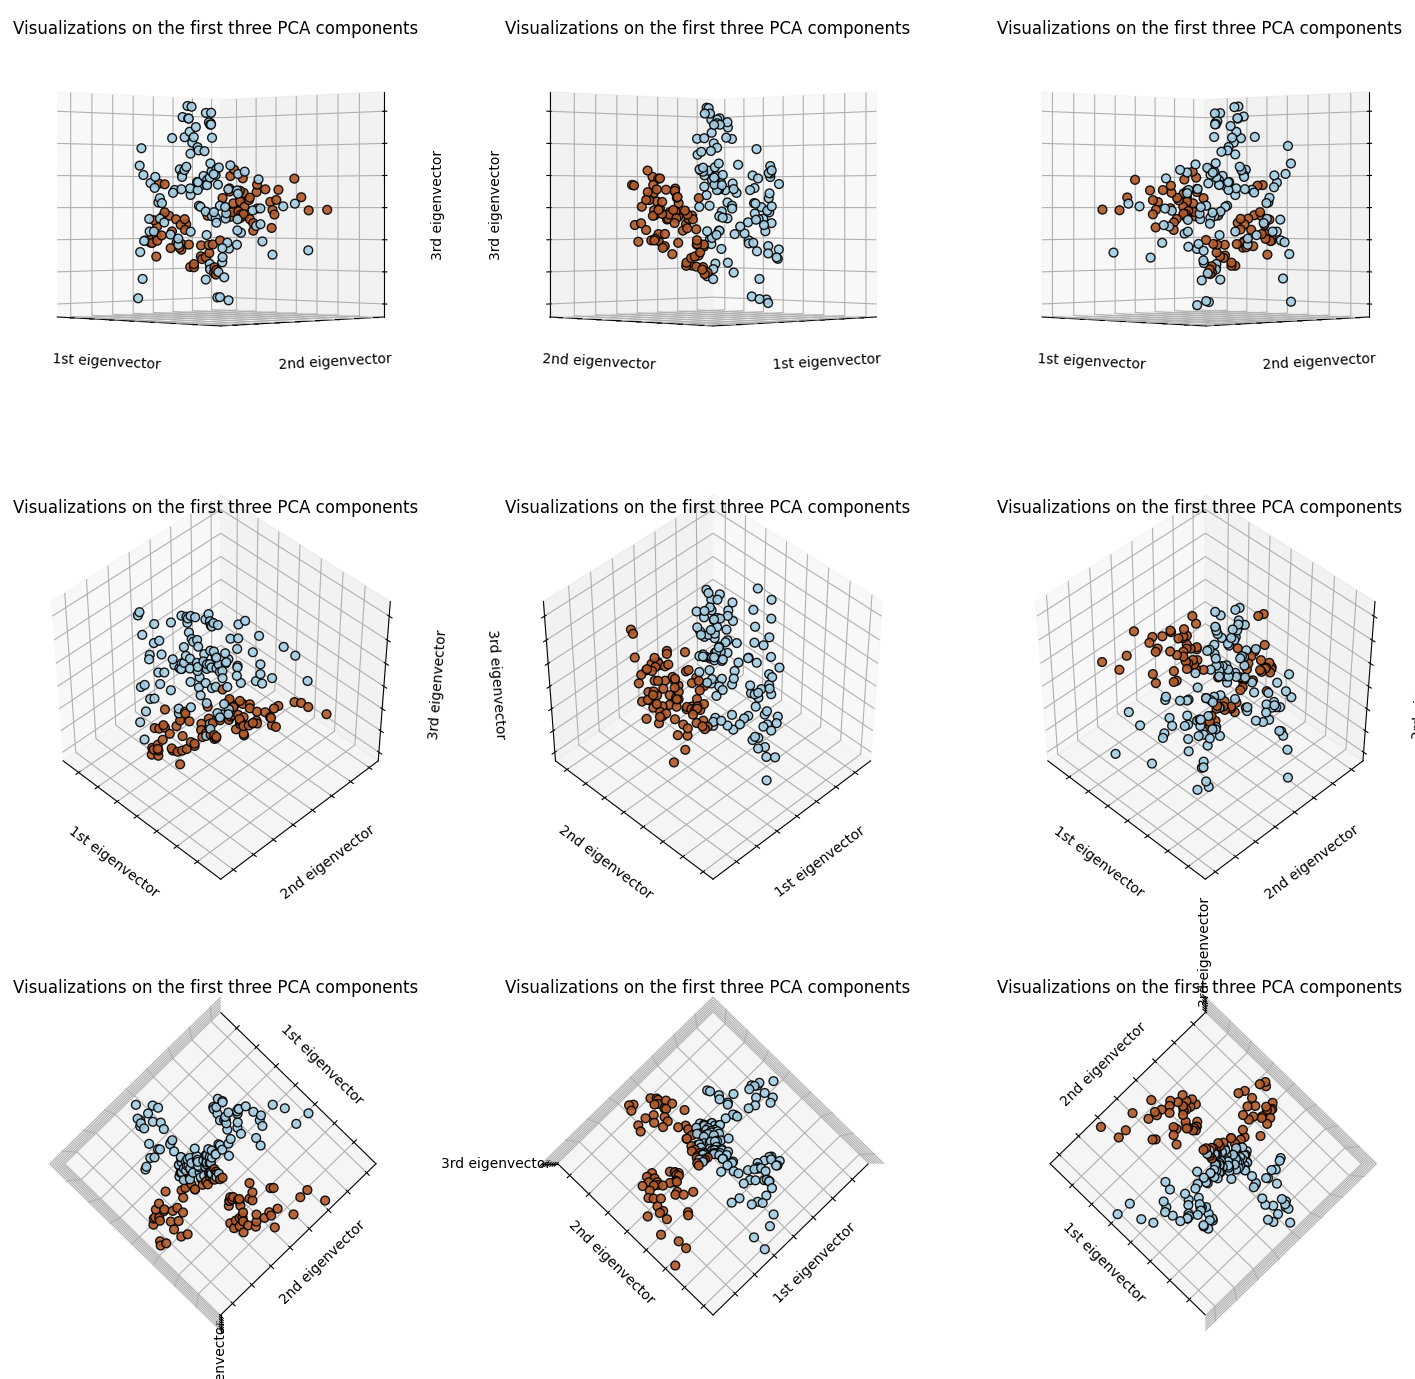

In [21]:
cv.labeling_data(2)
cv.visualize_clusters()

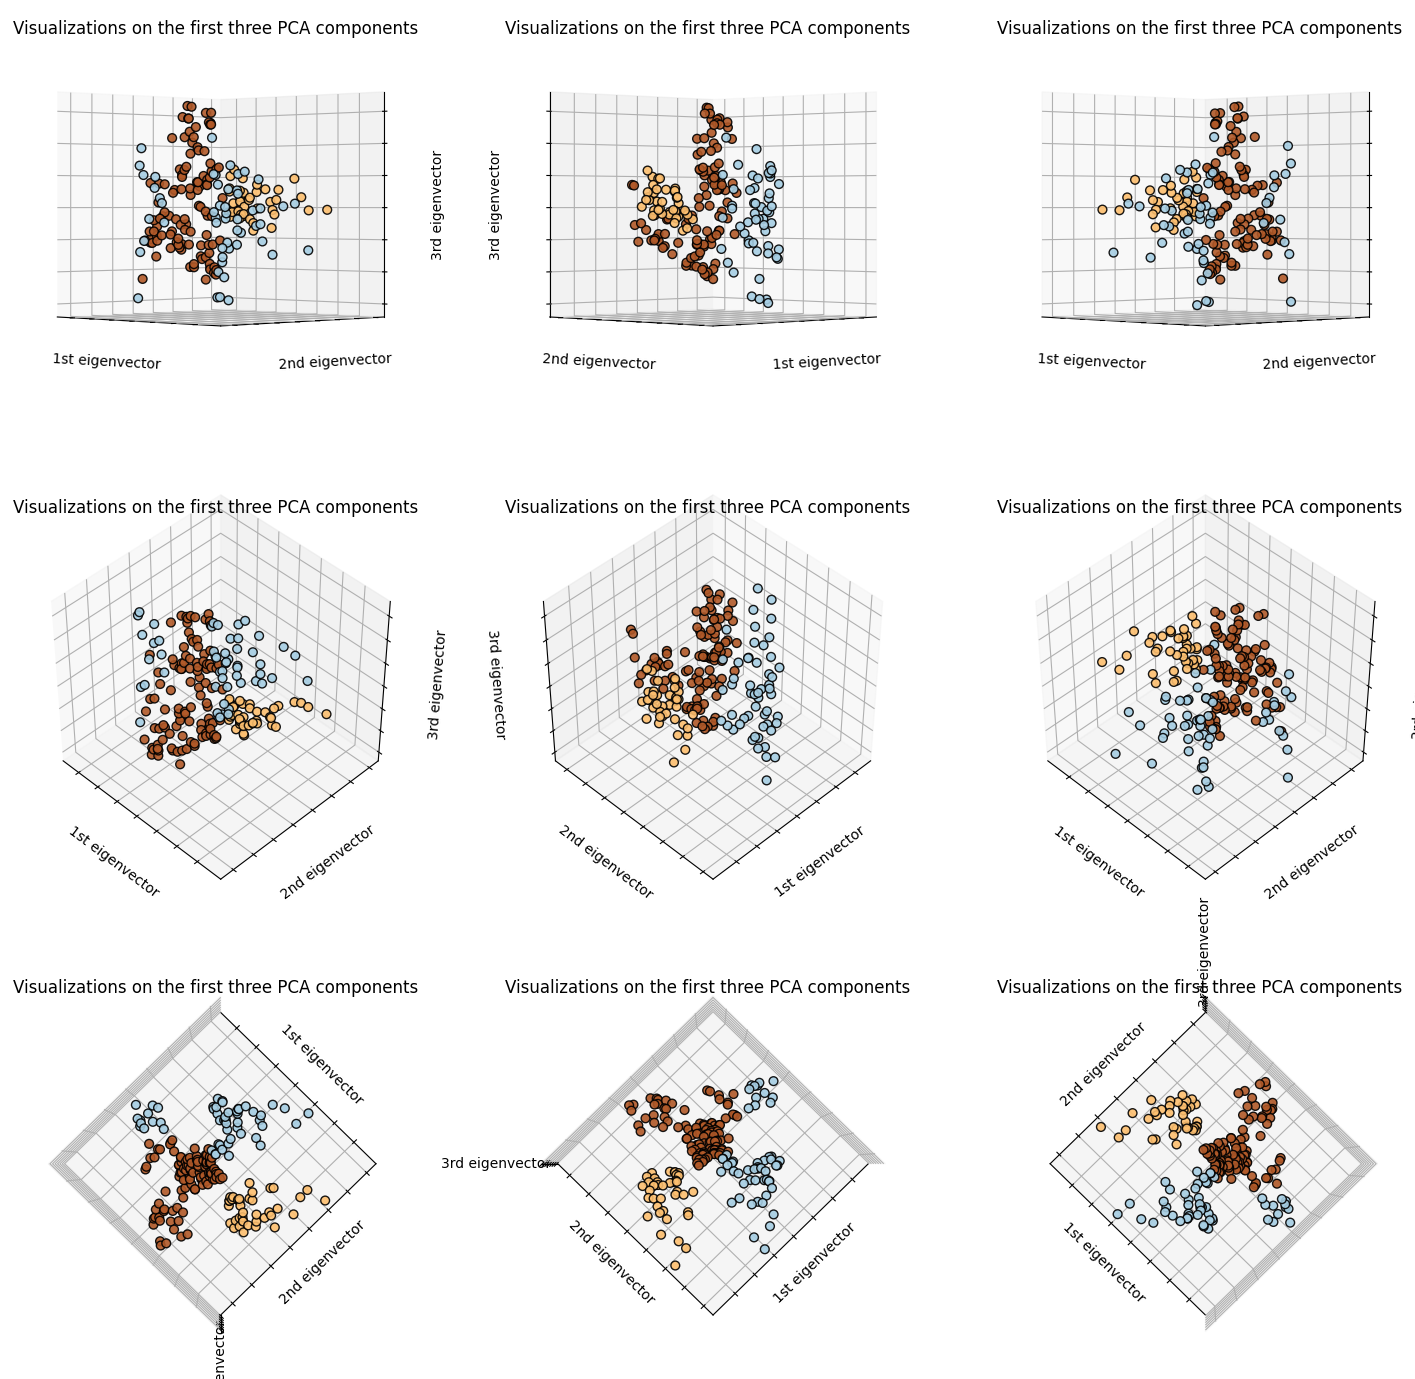

In [22]:
cv.labeling_data(3)
cv.visualize_clusters()

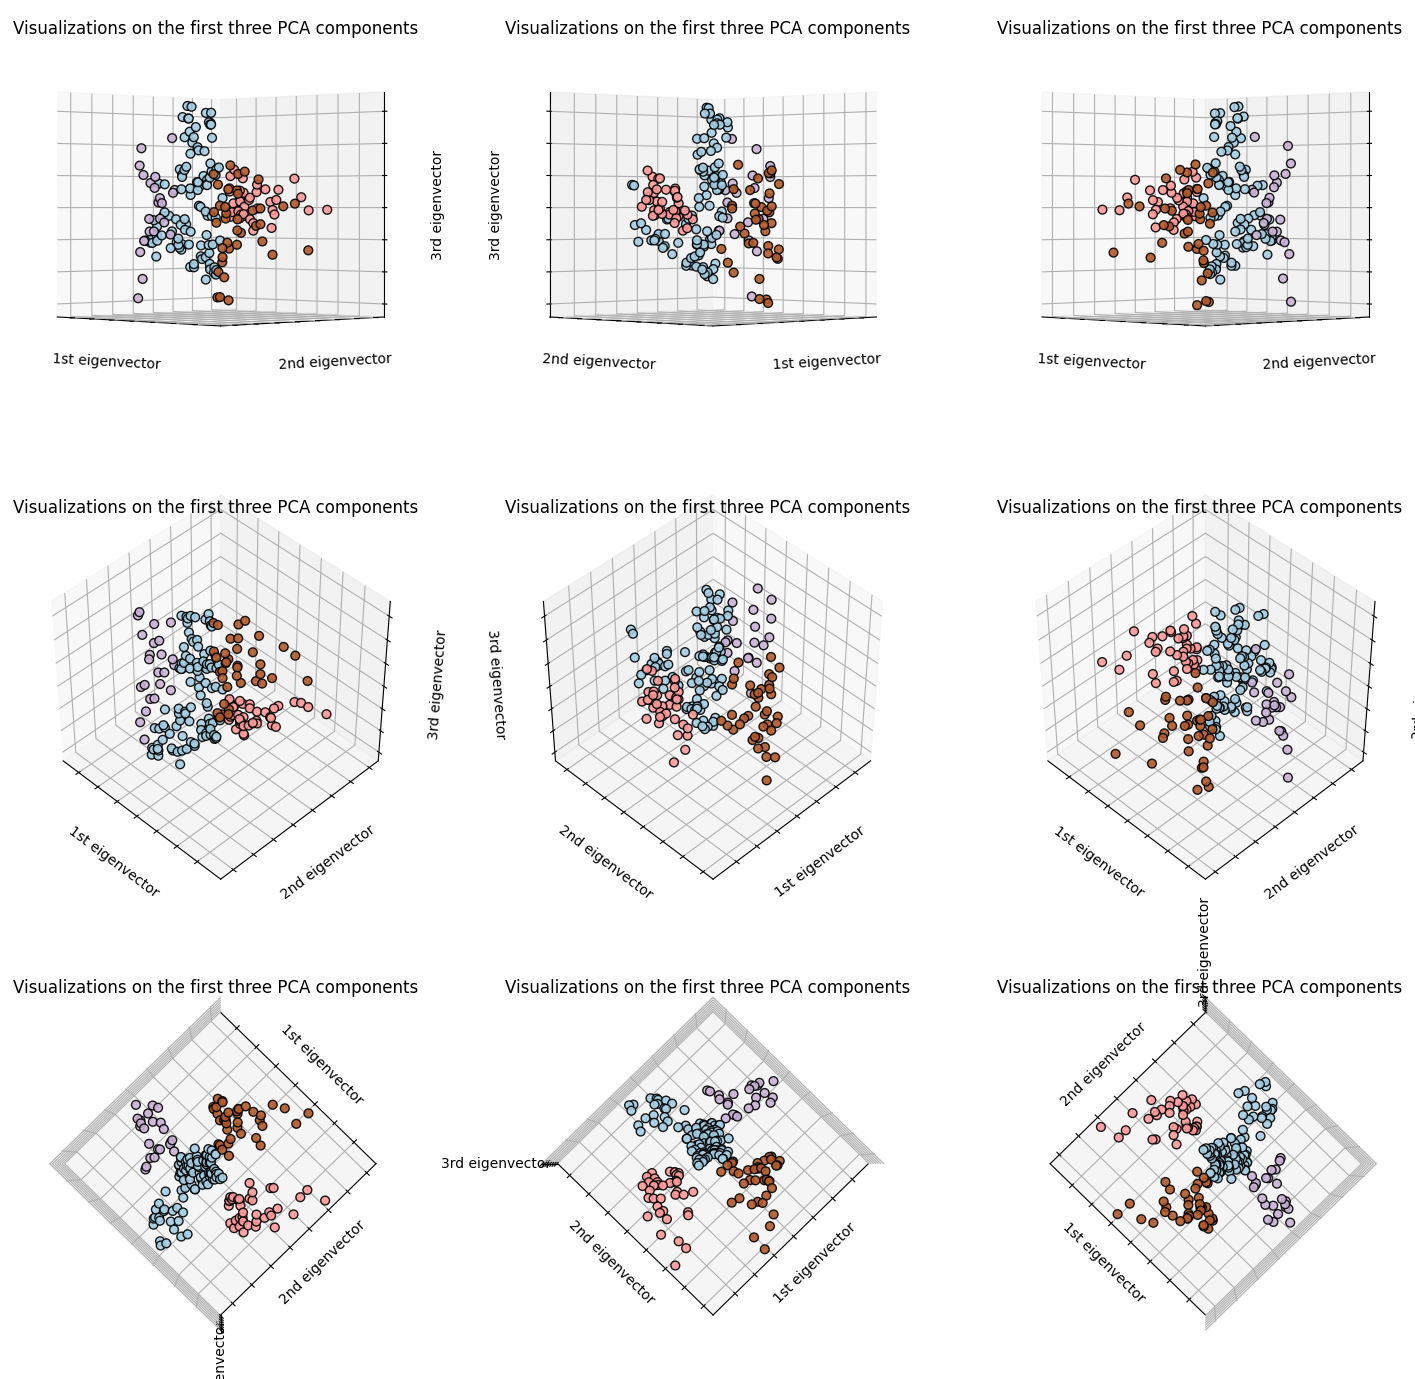

In [23]:
cv.labeling_data(4)
cv.visualize_clusters()

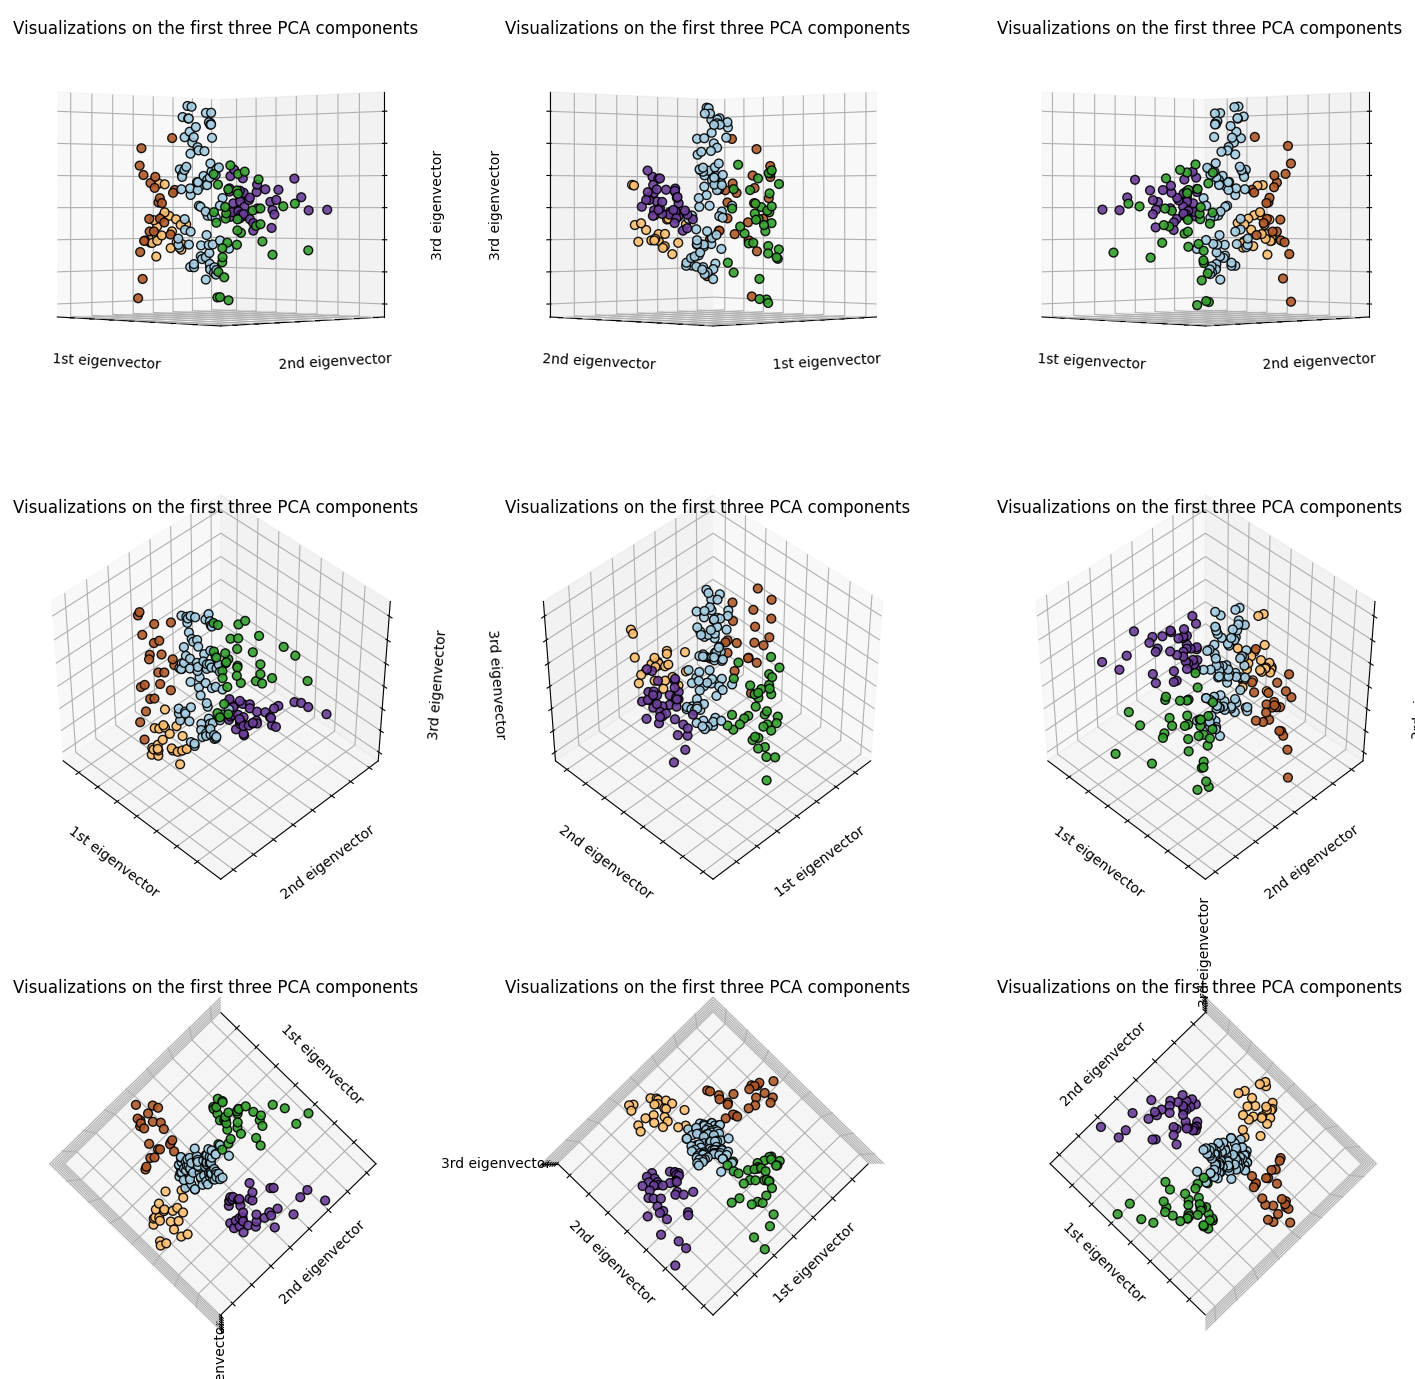

In [24]:
cv.labeling_data(5)
cv.visualize_clusters()

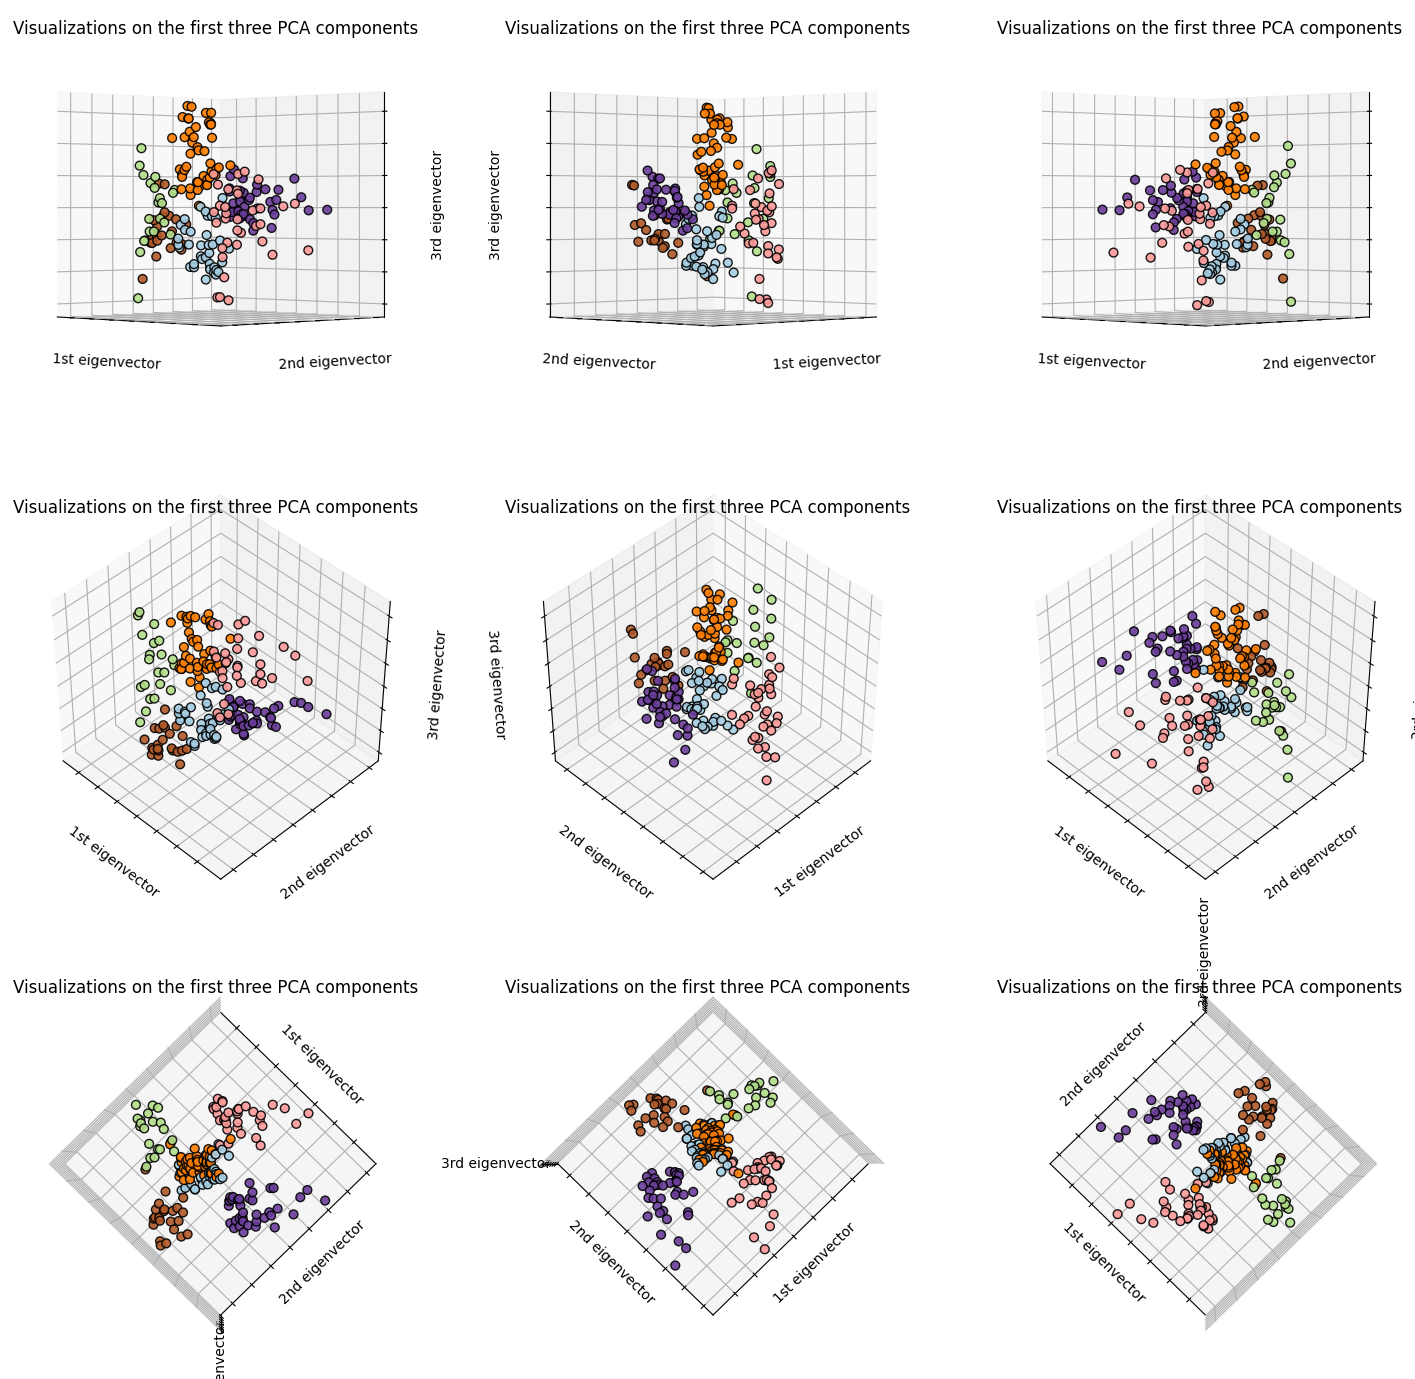

In [25]:
cv.labeling_data(6)
cv.visualize_clusters()

# 2. Consider the breast_cancer dataset given in the sklearn library and answer the following questions.

## 2.1 Import the breast_cancer dataset from sklearn.datasets library. (5 Points)

In [26]:
data = load_breast_cancer()

In [27]:
X = data['data']
y = data['target']
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [28]:
df = pd.DataFrame(X, columns=data['feature_names'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

mean radius                False
mean texture               False
mean perimeter             False
mean area                  False
mean smoothness            False
mean compactness           False
mean concavity             False
mean concave points        False
mean symmetry              False
mean fractal dimension     False
radius error               False
texture error              False
perimeter error            False
area error                 False
smoothness error           False
compactness error          False
concavity error            False
concave points error       False
symmetry error             False
fractal dimension error    False
worst radius               False
worst texture              False
worst perimeter            False
worst area                 False
worst smoothness           False
worst compactness          False
worst concavity            False
worst concave points       False
worst symmetry             False
worst fractal dimension    False
dtype: boo

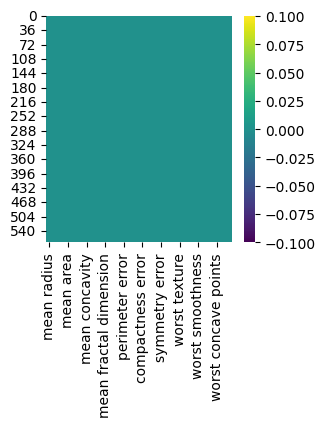

In [29]:
print(df.isnull().any())
plt.figure(figsize=(3, 3), dpi=100)
sns.heatmap(df.isnull(), cmap="viridis")

## 2.2 Perform PCA (2 components) and LDA (1 components) over the dataset. (20 Points)

#### 2.2.1. Perform LDA

In [30]:
lda = LinearDiscriminantAnalysis(n_components=None).fit(X, y)
print("="*50)
print("top components: %s" % lda.explained_variance_ratio_)
print("="*50)

top components: [1.]


#### 2.2.2. Perform PCA

In [31]:
pca = PCA(n_components=3).fit(X, y)
print("="*50)
print("top components: %s" % pca.explained_variance_ratio_)
print("="*50)

top components: [0.98204467 0.01617649 0.00155751]


## 2.3 Visualise the components and see if its able to segregate the class label in breast_cancer dataset. (10 Points)

***

LDA performs the best to segregate the class labels in breast_cancer dataset within one component.

***

#### 2.3.1. LDA visualization

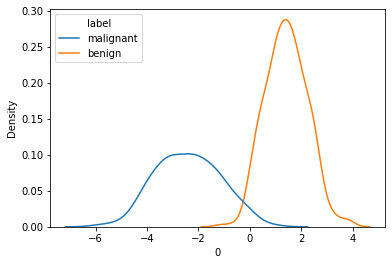

In [32]:
lda_df = pd.DataFrame(lda.transform(X))
lda_df['label'] = pd.Categorical.from_codes(y, data['target_names'])

sns.kdeplot(data=lda_df, x=0, hue='label')

***

Since there is only one component for the LDA output, I concat another variable to this result to make it performs better.

***

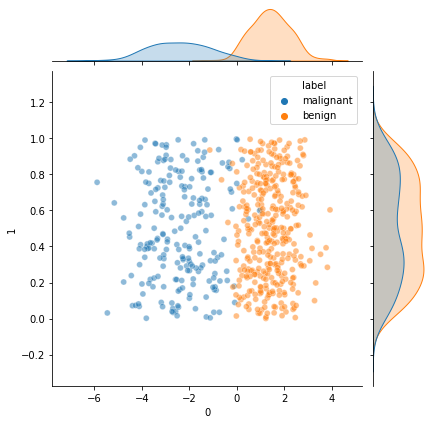

In [33]:
# append an extra dimension to visualise 2D
for lb in np.unique(lda_df['label'].values):
    l = lda_df[lda_df['label']==lb].shape[0]
    lda_df.loc[lda_df['label']==lb, 1] = np.random.uniform(0, 1, l) # np.random.normal(0, 1, l)
sns.jointplot(data=lda_df, x=0, y=1, hue="label", joint_kws={'alpha': 0.5})  # kind='kde', fill=True, 

#### 2.3.2. PCA visualization on breast cancer dataset

0           1          2      label
0    1160.142574 -293.917544  48.578398  malignant
1    1269.122443   15.630182 -35.394534  malignant
2     995.793889   39.156743  -1.709753  malignant
3    -407.180803  -67.380320   8.672848  malignant
4     930.341180  189.340742   1.374801  malignant
..           ...         ...        ...        ...
564  1414.126684  110.222492  40.065944  malignant
565  1045.018854   77.057589   0.036669  malignant
566   314.501756   47.553525 -10.442407  malignant
567  1124.858115   34.129225 -19.742087  malignant
568  -771.527622  -88.643106  23.889032     benign

[569 rows x 4 columns]

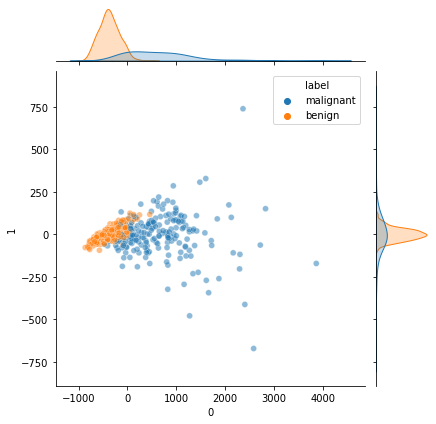

In [34]:
pca_df = pd.DataFrame(pca.transform(X))
pca_df['label'] = pd.Categorical.from_codes(y, data.target_names)
sns.jointplot(data=pca_df, x=0, y=1, hue="label", joint_kws={'alpha': 0.5})  # kind='kde', fill=True, 
pca_df

In [35]:
cv = ClassifierVisualization(X)
cv.df = pca_df
cv.target_name = 'label'
cv.y = LabelEncoder().fit_transform(pca_df[cv.target_name])
cv.df[cv.target_name] = cv.y

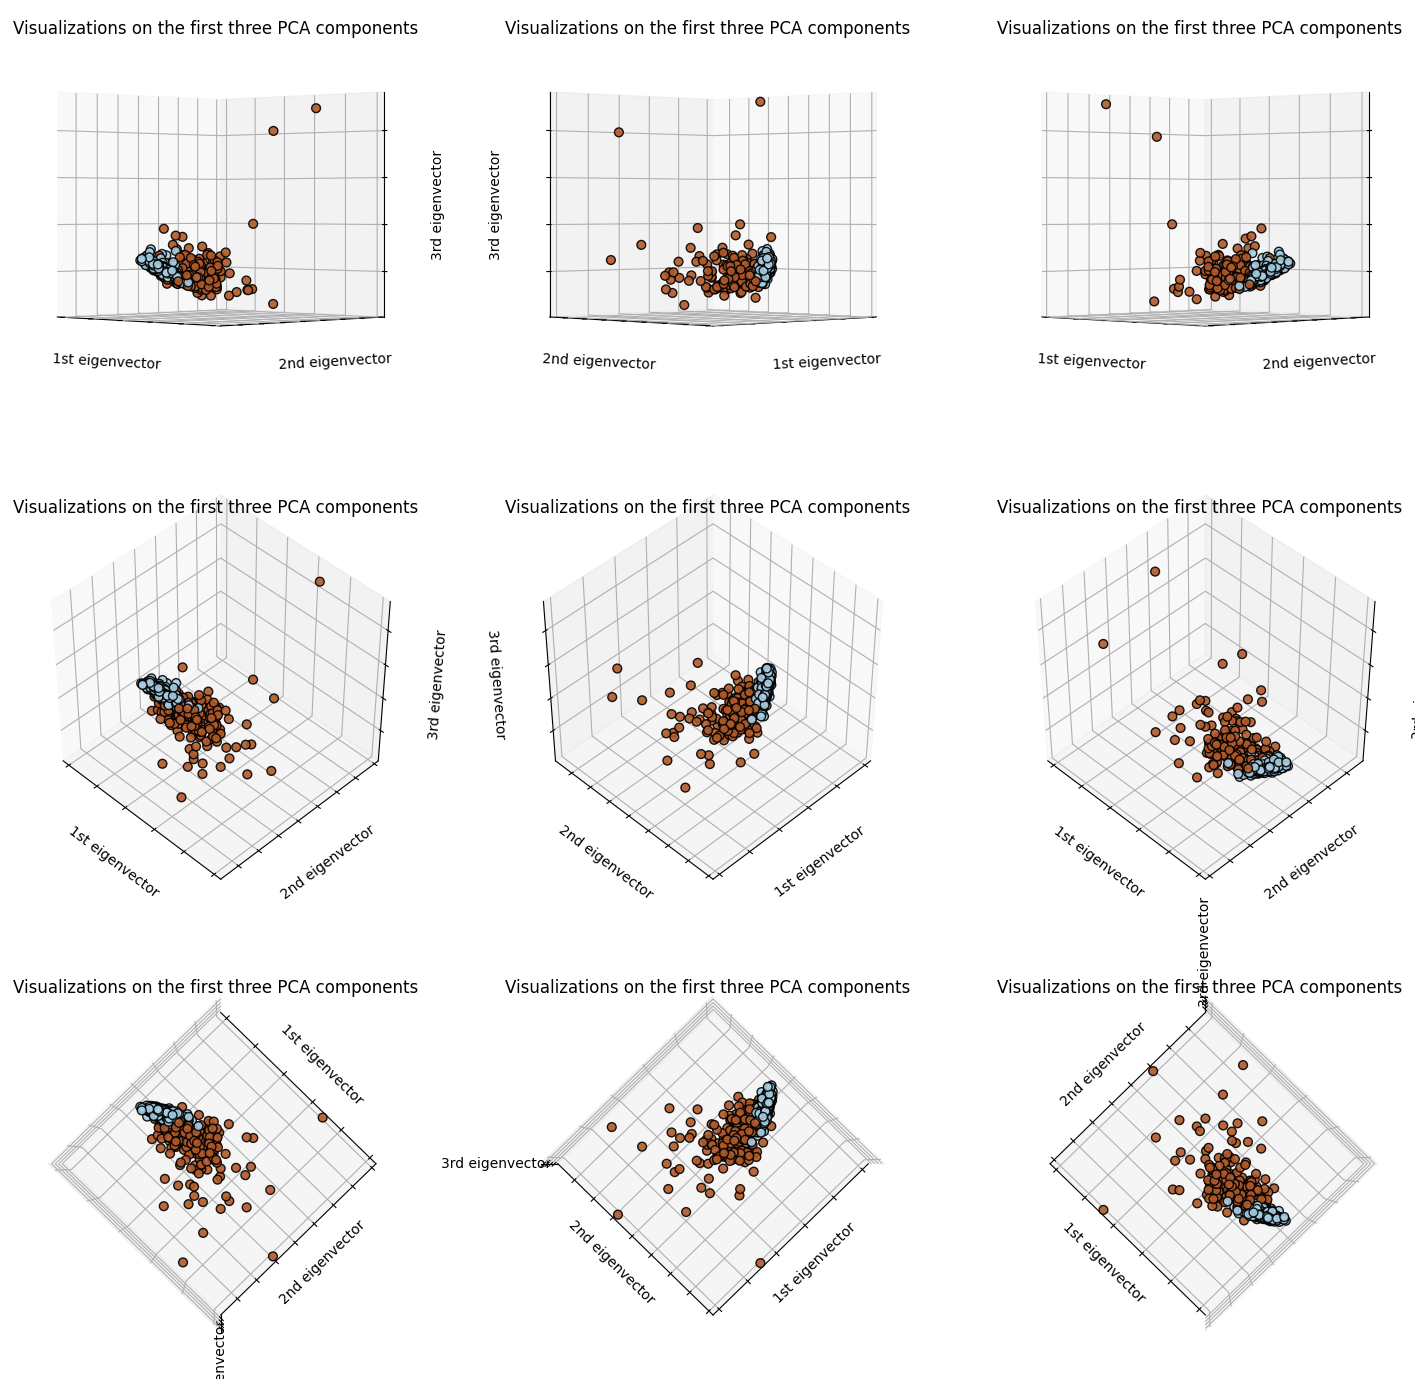

In [36]:
cv.visualize_clusters()

## 2.4 What is the maximum variance explained by both the components in PCA and LDA. (10 Points)

***

The first component of PCA explained 98.2% variance, while the first component of LDA explained 100.0% variance.

***

In [37]:
pca_score0 = pca.explained_variance_ratio_[0]
lda_score0 = lda.explained_variance_ratio_[0]
print("The first component of PCA explained %2.1f%% variance, while the first component of LDA explained %2.1f%% variance." % (pca_score0 * 100, lda_score0 * 100))


The first component of PCA explained 98.2% variance, while the first component of LDA explained 100.0% variance.


# 2.5 Comment on the working of PCA and LDA and which one is better for breast_cancer dataset. (5 Points)

***

As the plots shows, LDA performs much better on its first priciple component at the ratio of 100%. As a comparation, the first priciple component of PCA didn't performs that good. Because the optimal objective of PCA is to find the orthogonal basis that best explains the sample variances.

#### Compare against the variance ratio for PCA and LDA
top components of LDA: [1.], which means it captures 100% class separability of breast cancer dataset.

top components of PCA: [0.98204467, 0.01617649, 0.00155751], sum(pca.explained_variance_ratio_) = 99.98%, which means these top three components explans as much as 99.98% of the variances of the original breast cancer sample set.

#### The principle components obtained from PCA are different from those components from LDA
LDA principle components captures class separability. The ratios explains the classification performance of top LDA components. PCA principle components explains variances of each components. Top components offers more information about the data. The higher the eigen value is, the more information the eigen vector brings.

***